In [1]:
import sys
sys.path = [p for p in sys.path if p != '']  # Remove root

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr

import hugegp_cuda
import jaxkd as jk

import matplotlib.pyplot as plt
import time

key = jr.key(137)

In [3]:
def test_cov(r):
    result = (1 + (r/0.2)**2)**(-1)
    result = jnp.where(r == 0.0, result * (1 + 1e-4), result)
    return result

def test_cov_matrix(points_a, points_b=None):
    if points_b is None: points_b = points_a
    distances = jnp.expand_dims(points_a, -2) - jnp.expand_dims(points_b, -3)
    distances = jnp.linalg.norm(distances, axis=-1)
    return test_cov(distances)

def build_kd_graph(points, *, start_level, k):
    _, indices, split_dims = jk.build_tree(points, cuda=True)
    points = points[indices]
    neighbors = hugegp_cuda.query_coarse_neighbors(points, split_dims, k=k)
    n_levels = len(points).bit_length() - 1
    level_offsets = 1 << jnp.arange(start_level, n_levels + 1, dtype=jnp.uint32) - 1
    return points, neighbors, level_offsets

def generate(points, xi):
    L = jnp.linalg.cholesky(test_cov_matrix(points))
    values = L @ xi
    return values

In [4]:
# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))
points, neighbors, level_offsets = build_kd_graph(points, k=4, start_level=10)
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_points,))
initial_values = generate(points[:level_offsets[0]], xi[:level_offsets[0]])
cov_r, cov = jnp.zeros(1), jnp.zeros(1)

In [5]:
values = jax.jit(hugegp_cuda.refine)(points, xi, neighbors, level_offsets, initial_values, cov_r, cov)
values

Array([-0.64954567,  1.3869839 , -1.4624058 , ..., -0.5048989 ,
       -0.6253281 , -0.20141412], dtype=float32)

In [6]:
call = jax.ffi.ffi_call(
    "hugegp_cuda_refine_transpose_xla",
    (jax.ShapeDtypeStruct(xi.shape, jnp.float32), jax.ShapeDtypeStruct(initial_values.shape, jnp.float32))
)
dx, div = call(points, neighbors, level_offsets, cov_r, cov, jnp.ones_like(values))
dx

Array([0.        , 0.        , 0.        , ..., 0.01430881, 0.02525882,
       0.01594408], dtype=float32)

In [7]:
def func(xi, initial_values):
    return hugegp_cuda.refine(points, xi, neighbors, level_offsets, initial_values, cov_r, cov)

xi_tangent = jnp.zeros_like(xi)
xi_tangent = xi_tangent.at[70000].set(1.0)

_, dv = jax.jvp(func, (xi, initial_values,), (xi_tangent, jnp.zeros_like(initial_values),))

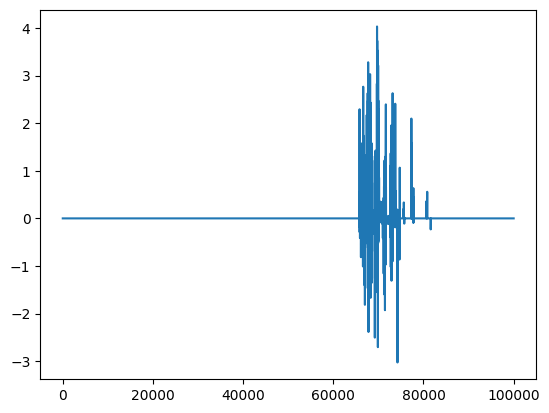

In [8]:
plt.plot(dv)

In [9]:
dx, div = jax.vjp(func, xi, initial_values)[1](jnp.ones_like(values))
dx[1023:]

Array([2.50584507e+01, 3.14202309e+01, 2.07460213e+01, ...,
       1.43088065e-02, 2.52588224e-02, 1.59440842e-02], dtype=float32)

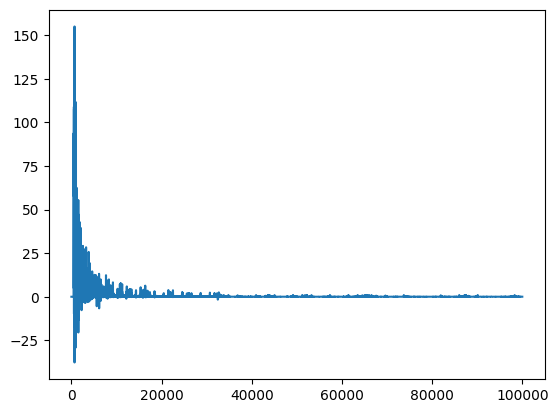

In [10]:
plt.plot(dx)

In [11]:
plt.scatter(*points[:level_indices[0]].T, c=initial_values, s=1, cmap='viridis')

NameError: name 'level_indices' is not defined

In [ ]:
start_time = time.time()

# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
tree = jk.build_tree(points, cuda=True)
indices = tree.indices
neighbors = hg.query_coarse_neighbors(points[indices], tree.split_dims, 4)
neighbors.block_until_ready()

build_time = time.time()

# Compute levels
start_level = 10
n_levels = n_points.bit_length() - 1
n_initial = 2 ** start_level - 1
level_offsets = 1 << jnp.arange(start_level, n_levels + 1, dtype=jnp.uint32)

# Random excitations
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_points,))

# Generate initial values
L = jnp.linalg.cholesky(test_cov_matrix(points[indices[:n_initial]]))
initial_values = L @ xi[indices[:n_initial]]

# Refine
values = hg.refine(points[indices], xi, neighbors, level_offsets, None, initial_values)
values.block_until_ready()

end_time = time.time()
print(f"Build time: {1000*(build_time - start_time):.0f} ms")
print(f"Refinement time: {1000*(end_time - build_time):.0f} ms")

values

Build time: 16 ms
Refinement time: 11 ms


Array([ 1.1264359 ,  0.22656697,  0.93657553, ..., -1.5698416 ,
       -1.6652716 , -0.774694  ], dtype=float32)

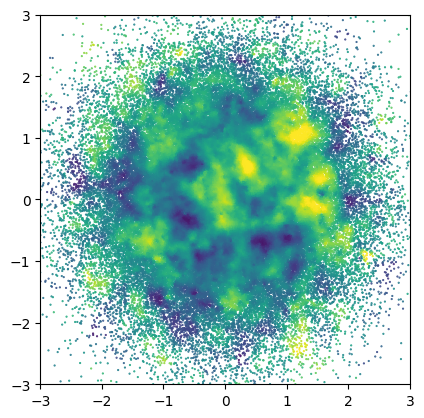

In [ ]:
plt.scatter(*points[indices].T, c=values, cmap='viridis', s=0.3, vmin=-3, vmax=3)
plt.gca().set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))
plt.show()